In [1]:
import pandas as pd
import matplotlib.pyplot as plt
!pip install finta
from finta import TA
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid, ParameterSampler
from google.colab import files
from tensorflow.keras.models import load_model
import os
from tensorflow.keras.utils import plot_model
!pip install mplfinance
import mplfinance as mpf

ModuleNotFoundError: No module named 'matplotlib'

In [3]:
#Import CSV with tabs as dataframe
df = pd.read_csv('EURUSD60.csv', sep='\t')

#Add column title to csv
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

#Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# See dimensions
print(df.shape)

#Get last values
df.tail()

#Get types of columns
print(df.dtypes)


#Get types of columns
print(df.head())

print(df.describe())


(99999, 6)
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object
                 Date     Open     High      Low    Close  Volume
0 2009-02-02 23:00:00  1.28150  1.28295  1.28070  1.28130    7915
1 2009-02-03 00:00:00  1.28115  1.28445  1.28090  1.28330   11417
2 2009-02-03 01:00:00  1.28340  1.28765  1.28235  1.28350   17108
3 2009-02-03 02:00:00  1.28350  1.28760  1.28310  1.28565   16310
4 2009-02-03 03:00:00  1.28560  1.29125  1.28520  1.29030   17493
                                Date          Open          High  \
count                          99999  99999.000000  99999.000000   
mean   2017-02-05 13:25:53.703537152      1.200981      1.201883   
min              2009-02-02 23:00:00      0.953900      0.955920   
25%              2013-01-31 15:30:00      1.099600      1.100395   
50%              2017-02-05 23:00:00      1.167830      1.168590   
75%              2021

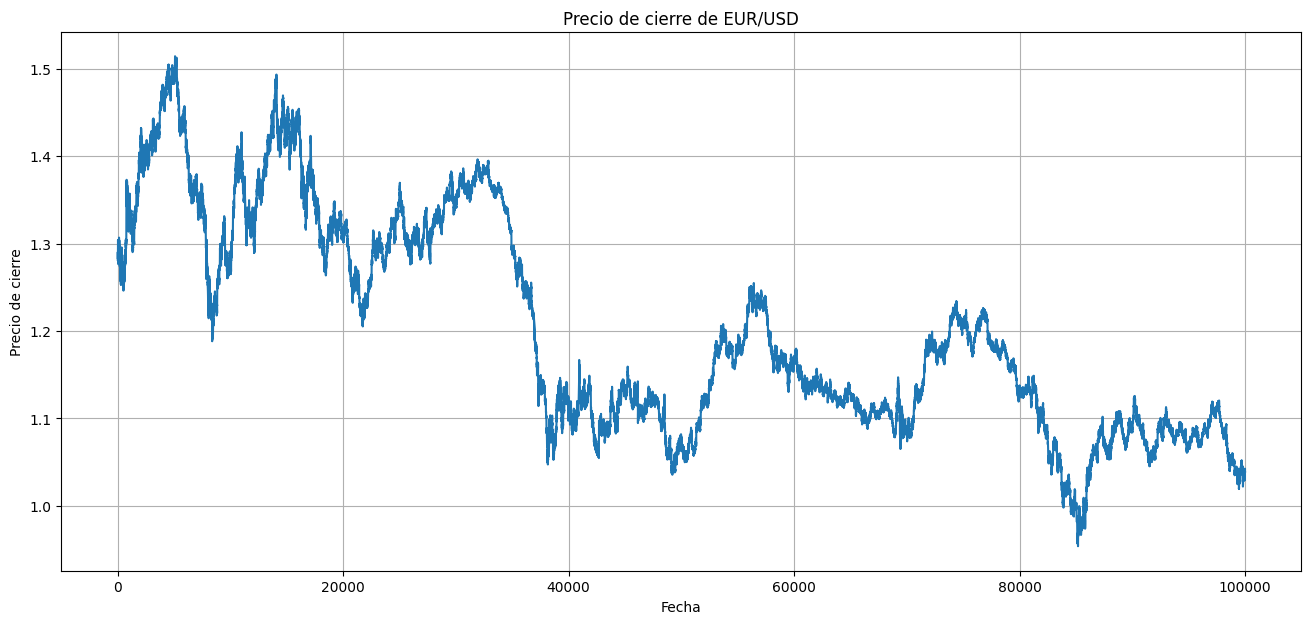

In [4]:
import matplotlib.pyplot as plt
# Plot the 'Close' price over time
plt.figure(figsize=(16, 7))
plt.plot(df['Close'])
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.title('Precio de cierre de EUR/USD')
plt.grid(True)
plt.show()


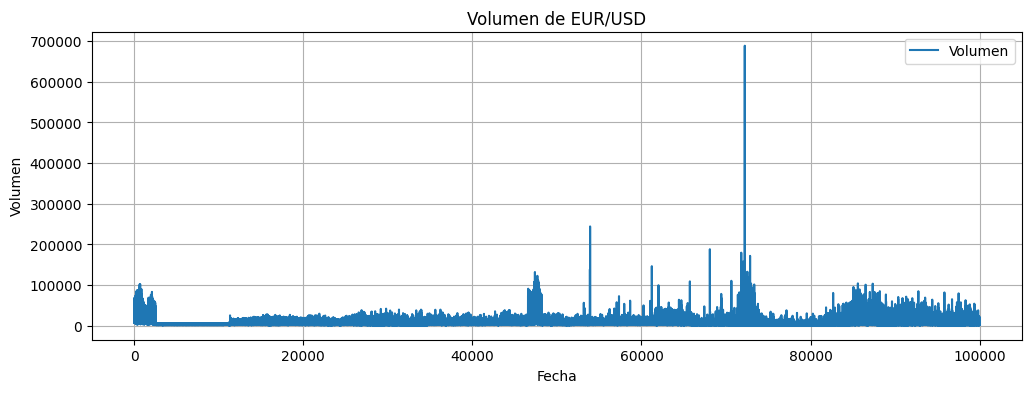

In [5]:
import matplotlib.pyplot as plt

# Assume `df` has columns: Date, Close, Volume
plt.figure(figsize=(12, 4))
plt.plot(df['Volume'], label='Volumen')
plt.title('Volumen de EUR/USD')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def validate_forex_data(df):
    print("\n🚫 Checking for negative and zero values:")
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        neg = (df[col] < 0).sum()
        zero = (df[col] == 0).sum()
        print(f"{col}: {neg} negative | {zero} zeros")

    print("\n❌ Checking logical inconsistencies:")
    invalid_high_low = df[df['High'] < df['Low']]
    if not invalid_high_low.empty:
        print(f"High < Low: {len(invalid_high_low)} rows")
    else:
        print("✅ No High < Low issues.")

    invalid_open = df[(df['Open'] < df['Low']) | (df['Open'] > df['High'])]
    print(f"Open outside High/Low: {len(invalid_open)} rows")

    invalid_close = df[(df['Close'] < df['Low']) | (df['Close'] > df['High'])]
    print(f"Close outside High/Low: {len(invalid_close)} rows")

    print("\n📈 Checking for sudden price jumps:")
    df['abs_change'] = df['Close'].pct_change().abs()
    sudden_jumps = df[df['abs_change'] > 0.05]
    print(f"Large Close changes (>5%): {len(sudden_jumps)} rows")

    print("\n📉 Checking for price flatlines:")
    df['delta'] = df['Close'].diff()
    flatlines = df[df['delta'] == 0]
    print(f"Unchanged consecutive Close prices: {len(flatlines)} rows")


In [7]:
raw_df = pd.read_csv('EURUSD60.csv', sep='\t')
raw_df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
validate_forex_data(raw_df)


🚫 Checking for negative and zero values:
Open: 0 negative | 0 zeros
High: 0 negative | 0 zeros
Low: 0 negative | 0 zeros
Close: 0 negative | 0 zeros
Volume: 0 negative | 0 zeros

❌ Checking logical inconsistencies:
✅ No High < Low issues.
Open outside High/Low: 0 rows
Close outside High/Low: 0 rows

📈 Checking for sudden price jumps:
Large Close changes (>5%): 0 rows

📉 Checking for price flatlines:
Unchanged consecutive Close prices: 665 rows


In [8]:
import numpy as np
import pandas as pd
from scipy.signal import periodogram
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

def estimate_seasonal_period(series, max_lag=500, plot=True):
    """
    Estimate the most likely seasonal period in a time series.

    Parameters:
        series (pd.Series): The time series data (e.g., df['Close'])
        max_lag (int): Max lags to consider for ACF/periodogram
        plot (bool): Whether to show the diagnostic plot

    Returns:
        int: Estimated period (in lags)
    """
    acf_vals = acf(series, nlags=max_lag)
    lags = np.arange(0, len(acf_vals))  # lags array for x-axis
    estimated_period = np.argmax(acf_vals)

    if plot:
      plt.figure(figsize=(8, 4))
      plt.stem(lags, acf_vals) # Changed max_lag to lags
      plt.title("Función de autocorrelación")
      plt.xlabel("Retardo")
      plt.ylabel("Autocorrelation")

      # 👇 Set Y-axis limits manually
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    print(f"Estimated period (ACF): {estimated_period}")

    freqs, power = periodogram(series)
    periods = 1 / freqs[1:]
    powers = power[1:]

    # Remove unrealistic values
    mask = (periods > 1) & (periods < max_lag)
    periods = periods[mask]
    powers = powers[mask]

    estimated_period = int(periods[np.argmax(powers)])

    if plot:
        plt.plot(periods, powers)
        plt.xlabel("Frecuencia en periodos")
        plt.ylabel("Potencia")
        plt.title("Periodograma")
        plt.grid(True)
        plt.show()

    print(f"Estimated period (Periodogram): {estimated_period}")

In [9]:
df['Close'].values
from statsmodels.tsa.stattools import acf
acf_vals = acf(df['Close'].values, nlags=8000)
print(acf_vals)

[1.         0.99992655 0.99985432 ... 0.50236064 0.50236159 0.5023634 ]


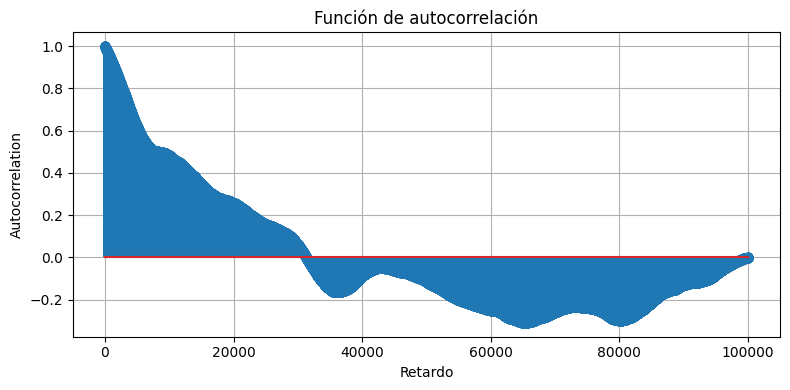

Estimated period (ACF): 0


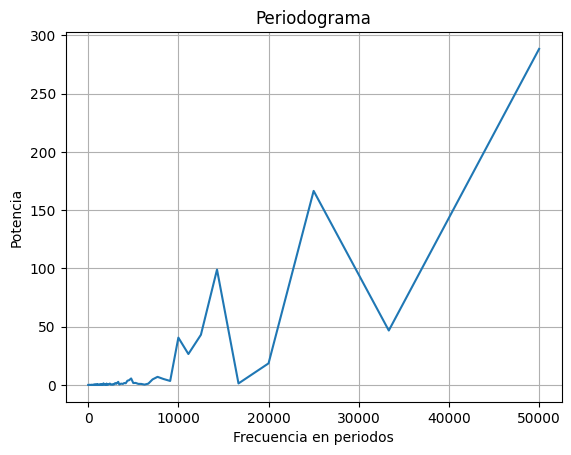

Estimated period (Periodogram): 49999


In [10]:
estimate_seasonal_period(df['Close'].values, max_lag=99999, plot=True)

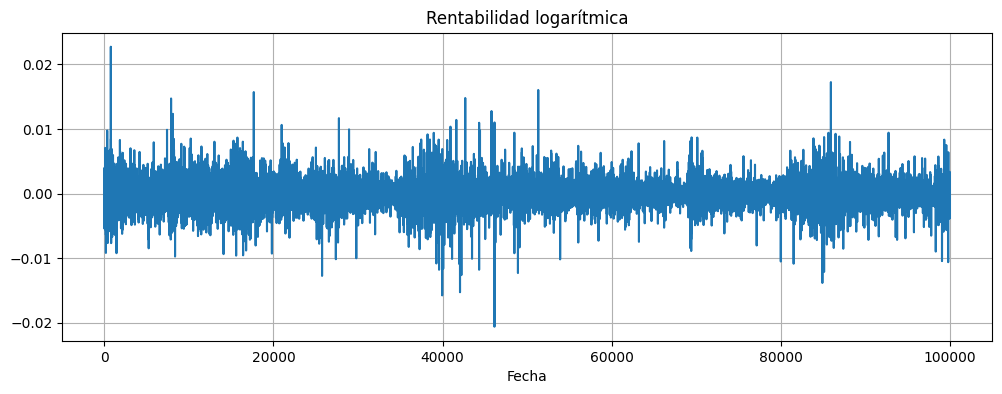

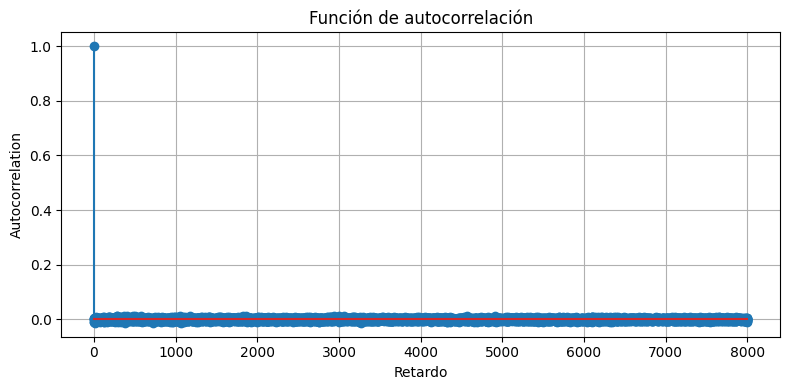

Estimated period (ACF): 0


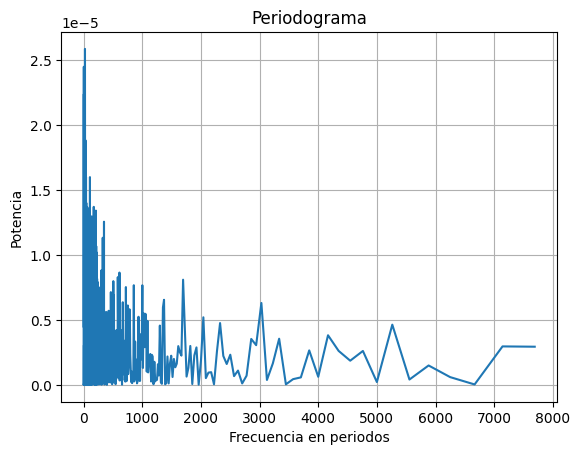

Estimated period (Periodogram): 21


In [11]:
log_returns = np.log(df['Close'] / df['Close'].shift(1)).dropna()

fig, ax = plt.subplots()
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(True)

log_returns.plot(figsize=(12, 4), title="Rentabilidad logarítmica", xlabel= "Fecha")
plt.grid(True)
plt.show()

estimate_seasonal_period(log_returns, max_lag=8000, plot=True)

no strong linear seasonality at period 21 for log retuns

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


def run_time_series_analysis(df):
    """
    Perform full time series analysis on Forex data.

    Parameters:
        df (DataFrame): Input DataFrame with time series data.
        date_col (str): Name of the datetime column.
        target_col (str): Name of the target price column (e.g., 'Close').
        period (int): Seasonal period (e.g., 24 for hourly to daily).
    """

    # Set datetime index
    df = df.copy()

    # ADF Test
    print("\n▶️ Augmented Dickey-Fuller Test...")
    adf_result = adfuller(df.dropna())
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    if adf_result[1] < 0.05:
        print("✅ Series is stationary")
    else:
        print("❌ Series is not stationary")

    # ACF and PACF plots
    print("\n▶️Partial Autocorrelation...")
    plot_pacf(df.dropna(), lags=50)
    plt.tight_layout()
    plt.show()



▶️ Augmented Dickey-Fuller Test...
ADF Statistic: -1.5583118863857632
p-value: 0.5044937259654503
❌ Series is not stationary

▶️Partial Autocorrelation...


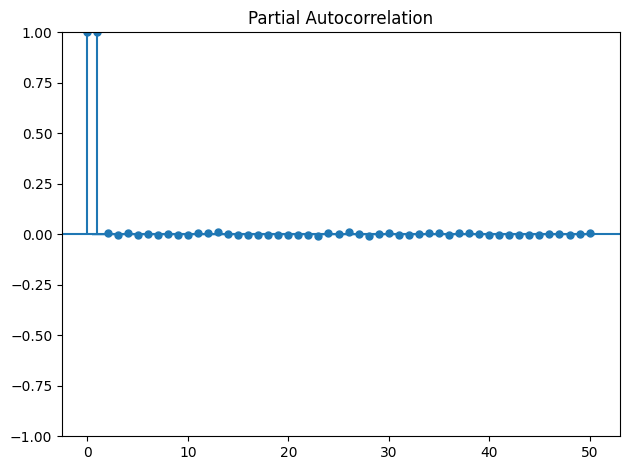

In [13]:
run_time_series_analysis(df['Close'])



▶️ Augmented Dickey-Fuller Test...
ADF Statistic: -59.42350524432337
p-value: 0.0
✅ Series is stationary

▶️Partial Autocorrelation...


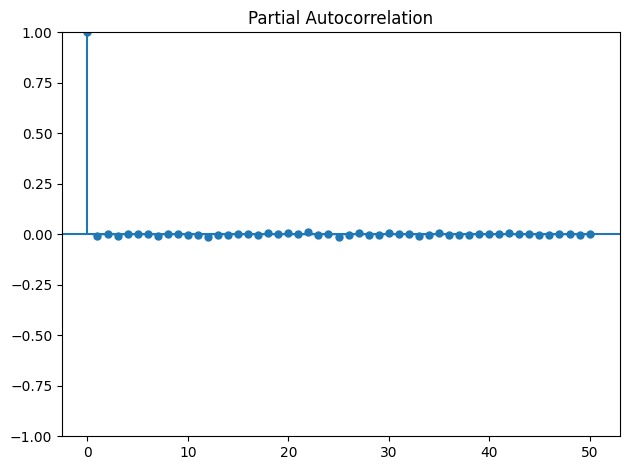

In [14]:
run_time_series_analysis(log_returns)

In [15]:
# Compute log return
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))

# ────────────────────────────────
# 📊 Lag Features
# ────────────────────────────────
df['lag_1'] = df['Close'].shift(1)

# ────────────────────────────────
# 📈 Rolling Statistics
# ────────────────────────────────
df['rolling_mean_5'] = df['Close'].rolling(window=5).mean()
df['rolling_std_5'] = df['Close'].rolling(window=5).std()
df['rolling_mean_24'] = df['Close'].rolling(window=24).mean()
df['rolling_std_24'] = df['Close'].rolling(window=24).std()

# ────────────────────────────────
# 📐 Price Ratios & Differentials
# ────────────────────────────────
df['hl_ratio'] = df['High'] / df['Low']
df['oc_diff'] = df['Open'] - df['Close']
df['close_ma_diff'] = df['Close'] - df['rolling_mean_24']

# ────────────────────────────────
# ⏳ Time-Based / Cyclical Features
# ────────────────────────────────
df['is_weekend'] = (df['Date'].dt.dayofweek == 6).astype(int)

# Fourier encodings
df['sin_hour'] = np.sin(2 * np.pi * df['Date'].dt.hour / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['Date'].dt.hour / 24)

df['sin_day'] = np.sin(2 * np.pi * df['Date'].dt.dayofweek / 7)
df['cos_day'] = np.cos(2 * np.pi * df['Date'].dt.dayofweek / 7)

# ────────────────────────────────
# 🔁 Momentum / TA Indicators
# ────────────────────────────────
df['RSI'] = TA.RSI(df)
df['ATR'] = TA.ATR(df)
df['EMA_12'] = TA.EMA(df, 12)
df['EMA_26'] = TA.EMA(df, 26)

# ────────────────────────────────
# ⚡ Volatility
# ────────────────────────────────
df['abs_return'] = df['log_return'].abs()
df['squared_return'] = df['log_return']**2
df['volatility_24'] = df['log_return'].rolling(24).std()


# ────────────────────────────────
# 🧹 Clean up NaNs caused by rolling/lags
# ────────────────────────────────
df.dropna(inplace=True)
df.reset_index(drop=True)

# Set date as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# List of new features
new_features = ['log_return', 'lag_1', 'rolling_mean_5', 'rolling_std_5', 'rolling_mean_24', 'rolling_std_24', 'hl_ratio', 'oc_diff', 'close_ma_diff', 'is_weekend', 'sin_hour', 'cos_hour', 'sin_day', 'cos_day', 'RSI', 'ATR', 'EMA_12', 'EMA_26', 'abs_return', 'squared_return', 'volatility_24']

In [16]:
len(new_features)

21

In [17]:
df[new_features].describe()

,log_return,lag_1,rolling_mean_5,rolling_std_5,rolling_mean_24,rolling_std_24,hl_ratio,oc_diff,close_ma_diff,is_weekend,...,cos_hour,sin_day,cos_day,RSI,ATR,EMA_12,EMA_26,abs_return,squared_return,volatility_24
count,99975.000000,99975.000000,99975.000000,99975.000000,99975.000000,99975.000000,99975.000000,9.997500e+04,99975.000000,99975.000000,...,9.997500e+04,99975.000000,99975.000000,99975.000000,99975.000000,99975.000000,99975.000000,99975.000000,9.997500e+04,99975.000000
mean,-0.000002,1.200962,1.200965,0.001011,1.200989,0.002273,1.001478,1.670418e-08,-0.000029,0.022086,...,5.285230e-04,0.343705,-0.046630,49.803589,0.001795,1.200974,1.200992,0.000719,1.266436e-06,0.001012
std,0.001125,0.122796,0.122789,0.000918,0.122758,0.001575,0.001159,1.358066e-03,0.003695,0.146962,...,7.071234e-01,0.527966,0.775212,12.657686,0.000914,0.122770,0.122739,0.000866,5.282390e-06,0.000495
min,-0.020605,0.953900,0.955028,0.000000,0.957739,0.000028,1.000000,-3.022000e-02,-0.036425,0.000000,...,-1.000000e+00,-0.781831,-0.900969,6.986076,0.000105,0.956344,0.958086,0.000000,0.000000e+00,0.000023
25%,-0.000451,1.099590,1.099584,0.000427,1.099598,0.001201,1.000724,-5.400000e-04,-0.001863,0.000000,...,-7.071068e-01,0.000000,-0.900969,40.992395,0.001128,1.099565,1.099591,0.000193,3.743529e-08,0.000666
50%,0.000000,1.167790,1.167856,0.000740,1.168076,0.001847,1.001170,0.000000e+00,0.000007,0.000000,...,6.123234e-17,0.433884,-0.222521,49.922589,0.001575,1.167963,1.167991,0.000452,2.038592e-07,0.000907
75%,0.000452,1.309495,1.309529,0.001279,1.309464,0.002858,1.001869,5.300000e-04,0.001842,0.000000,...,7.071068e-01,0.781831,0.623490,58.659007,0.002255,1.309468,1.309418,0.000928,8.612200e-07,0.001230
max,0.022735,1.514200,1.513394,0.018724,1.509735,0.020406,1.025528,2.288000e-02,0.040516,1.000000,...,1.000000e+00,0.974928,1.000000,94.224972,0.010181,1.510724,1.509024,0.022735,5.168810e-04,0.005849


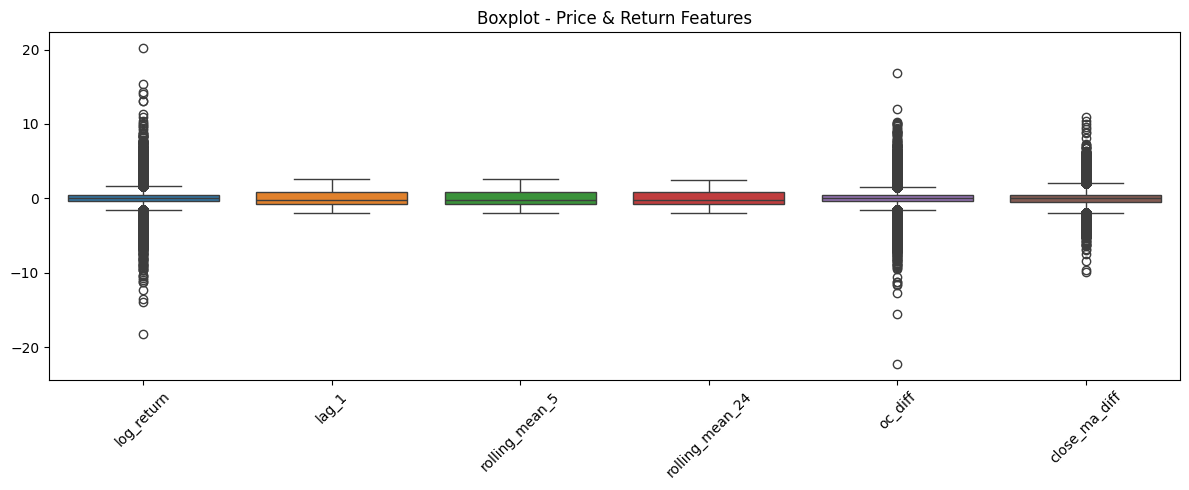

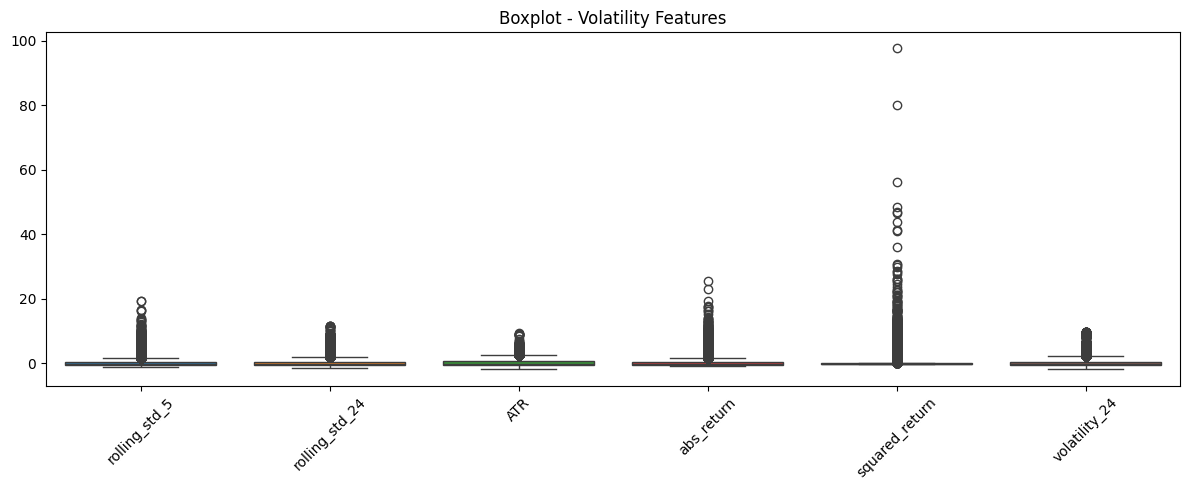

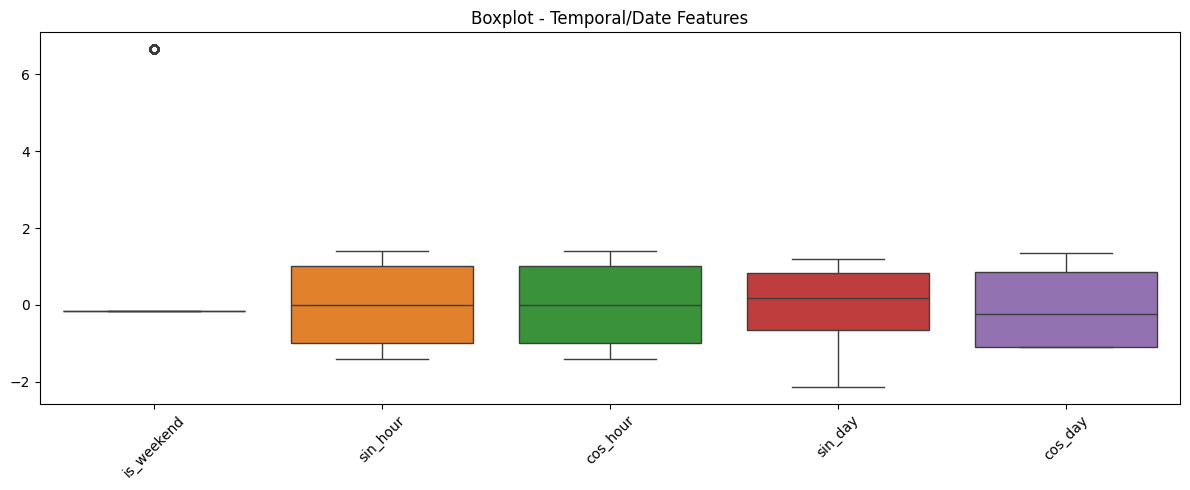

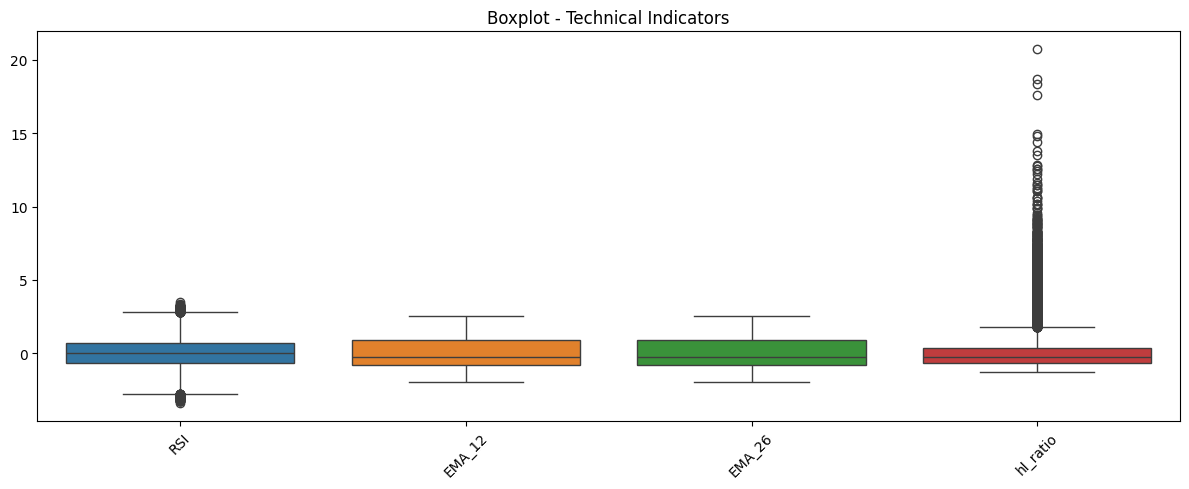

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ─────────────────────────────
# 📦 1. Define feature groups
# ─────────────────────────────
group_price_return = [
    'log_return', 'lag_1', 'rolling_mean_5', 'rolling_mean_24',
    'oc_diff', 'close_ma_diff'
]

group_volatility = [
    'rolling_std_5', 'rolling_std_24', 'ATR', 'abs_return',
    'squared_return', 'volatility_24'
]

group_time = [
    'is_weekend', 'sin_hour', 'cos_hour', 'sin_day', 'cos_day'
]

group_technical = [
    'RSI', 'EMA_12', 'EMA_26', 'hl_ratio'
]

# Combine all selected features (if needed for scaling)
all_selected = group_price_return + group_volatility + group_time + group_technical

# ─────────────────────────────
# 🔍 2. Scale the features
# ─────────────────────────────
scaled_df = pd.DataFrame(
    StandardScaler().fit_transform(df[all_selected]),
    columns=all_selected
)

# ─────────────────────────────
# 📊 3. Define boxplot function
# ─────────────────────────────
def plot_box_group(dataframe, features, title):
    plt.figure(figsize=(12, 5))
    sns.boxplot(data=dataframe[features])
    plt.xticks(rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ─────────────────────────────
# 📈 4. Plot each group
# ─────────────────────────────
plot_box_group(scaled_df, group_price_return, "Boxplot - Price & Return Features")
plot_box_group(scaled_df, group_volatility, "Boxplot - Volatility Features")
plot_box_group(scaled_df, group_time, "Boxplot - Temporal/Date Features")
plot_box_group(scaled_df, group_technical, "Boxplot - Technical Indicators")


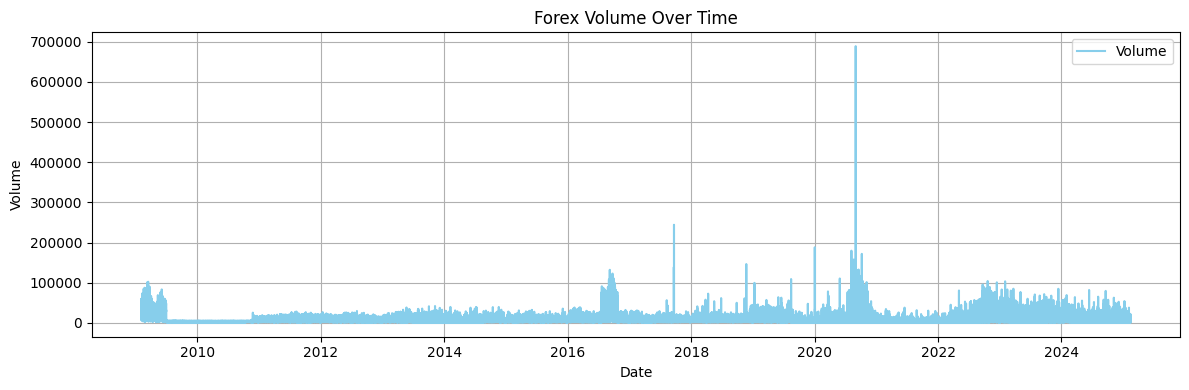

In [19]:
# Assume `df` has columns: Date, Close, Volume
plt.figure(figsize=(12, 4))
plt.plot(df['Volume'], label='Volume', color='skyblue')
plt.title('Forex Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

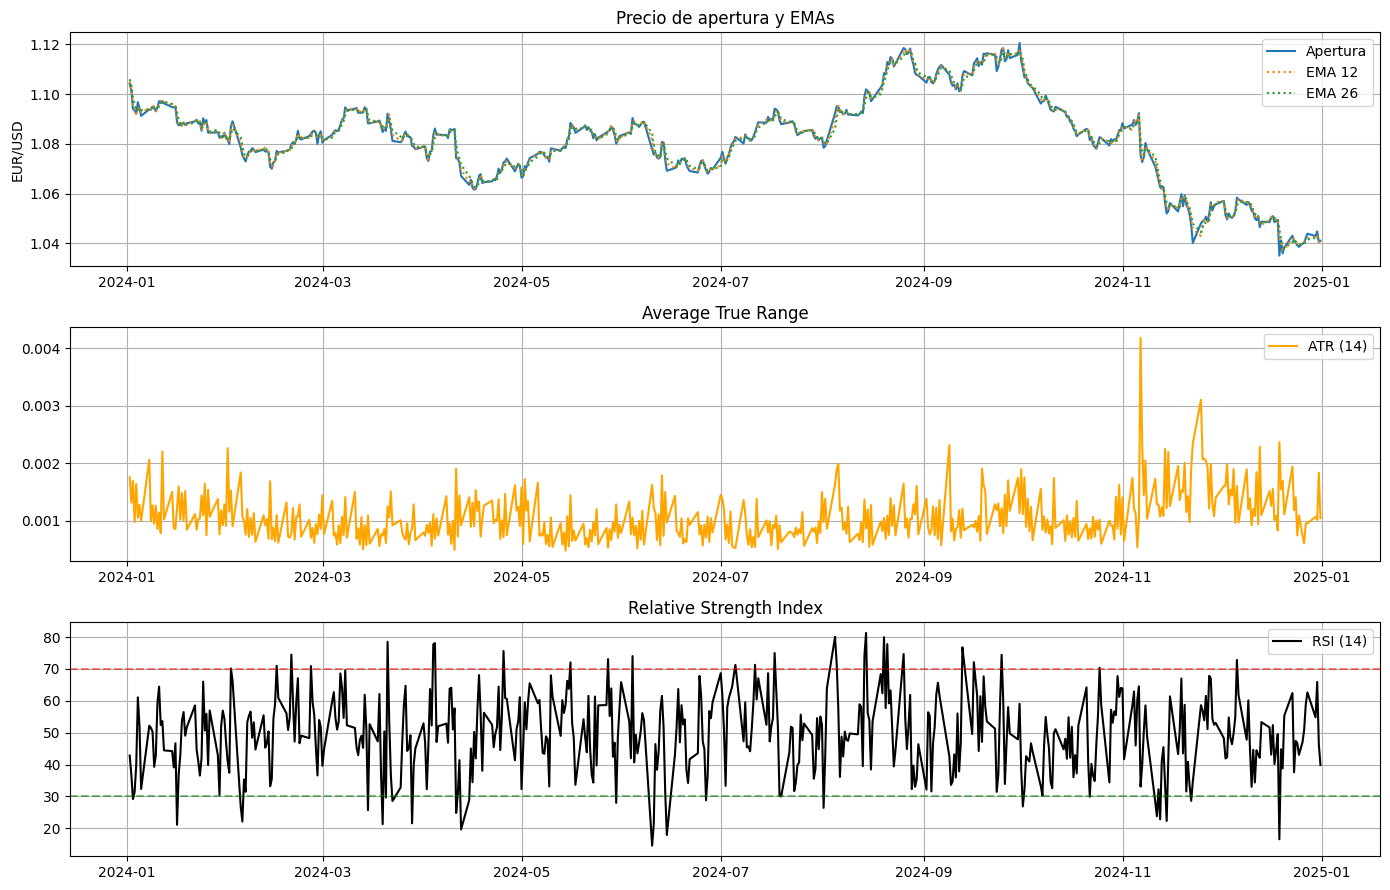

In [20]:
#df only 2024
df_copy = df.copy()
df_copy = df_copy[df_copy.index.year == 2024]

#take every 12 rows
df_copy = df_copy.iloc[::12]

plt.figure(figsize=(14, 9))
plt.subplot(3, 1, 1)
plt.plot(df_copy.Open)
plt.plot(df_copy.EMA_12, ls=':')
plt.plot(df_copy.EMA_26, ls=':')
plt.grid(True)
plt.legend(['Apertura', 'EMA 12', 'EMA 26'])
plt.title('Precio de apertura y EMAs')
plt.ylabel('EUR/USD')

plt.subplot(3, 1, 2)
plt.plot(df_copy['ATR'], label='ATR (14)', color='orange')
plt.title('Average True Range')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df_copy['RSI'], label='RSI (14)', color='black')
plt.axhline(70, color='red', linestyle='--', alpha=0.5)
plt.axhline(30, color='green', linestyle='--', alpha=0.5)
plt.title('Relative Strength Index')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

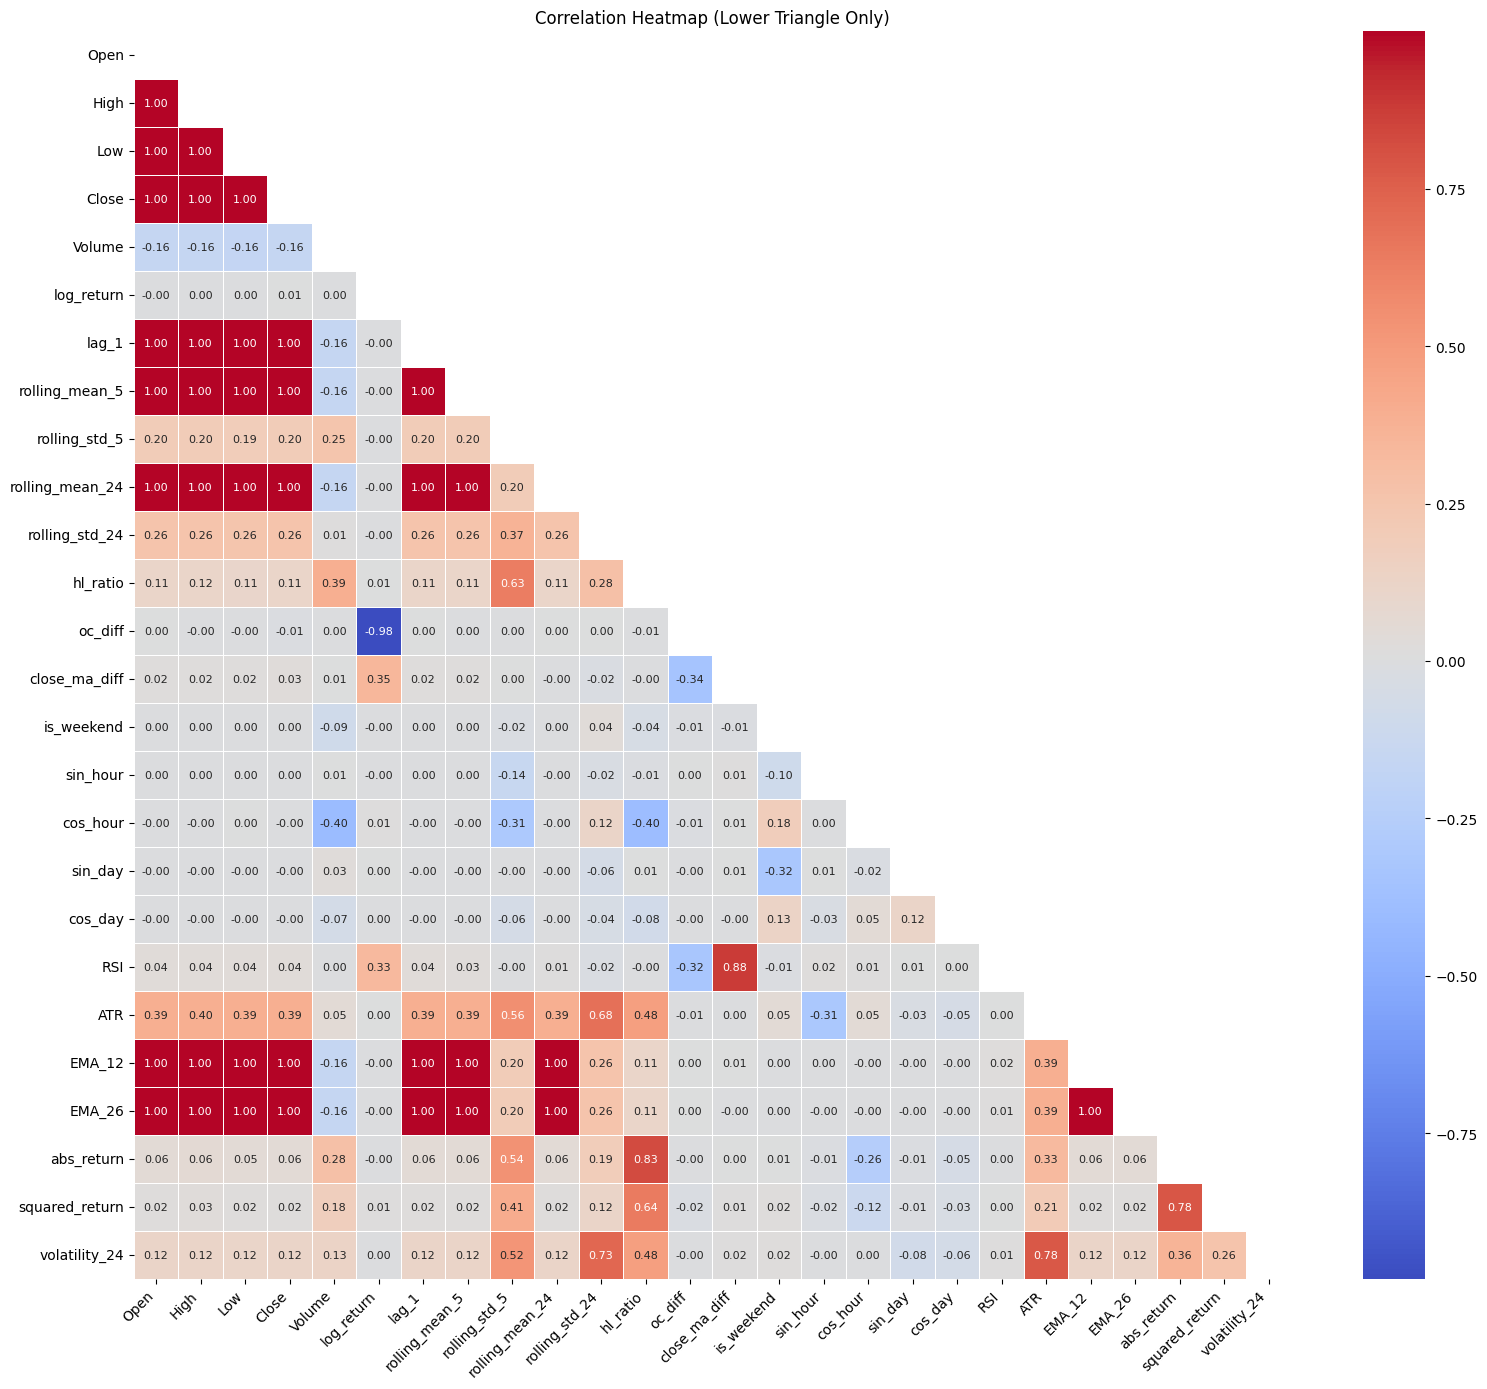

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factor (VIF):
            Feature           VIF
0              Open           inf
1              High  7.003011e+06
2               Low  7.364759e+06
3             Close           inf
4            Volume  2.522335e+00
5        log_return  8.579760e+01
6             lag_1  9.876632e+07
7    rolling_mean_5  7.446241e+06
8     rolling_std_5  4.676361e+00
9   rolling_mean_24           inf
10   rolling_std_24  7.610401e+00
11         hl_ratio  2.327931e+02
12          oc_diff           inf
13    close_ma_diff           inf
14       is_weekend  1.239947e+00
15         sin_hour  1.597153e+00
16         cos_hour  1.661716e+00
17          sin_day  1.666330e+00
18          cos_day  1.063477e+00
19              RSI  9.041466e+01
20              ATR  3.006187e+01
21           EMA_12  1.310804e+07
22           EMA_26  4.431222e+06
23       abs_return  8.554643e+00
24   squared_return  2.901675e+00
25    volatility_24  2.377520e+01


In [21]:
# Calcular matriz de correlación
correlation_matrix = df.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(16, 14))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.title("Correlation Heatmap (Lower Triangle Only)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calcular VIF para cada variable
vif_data = pd.DataFrame()
# 👇 Select only numerical features for VIF calculation
numerical_features = df.select_dtypes(include=np.number).columns
vif_data["Feature"] = numerical_features
vif_data["VIF"] = [variance_inflation_factor(df[numerical_features].dropna().values, i) for i in range(len(numerical_features))]


# Mostrar VIF
print("Variance Inflation Factor (VIF):")
print(vif_data)


In [22]:
from sklearn.preprocessing import StandardScaler

selected_features = [
    'Close',
    'log_return',
    'rolling_std_5',
    'is_weekend',
    'sin_hour', 'cos_hour',
    'sin_day', 'cos_day',
    'RSI',
    'ATR',
    'abs_return',
    'Volume'
]

# Split your dataset (assuming you've done train/test split)
train_df = df[selected_features].iloc[:int(len(df)*0.8)]
test_df  = df[selected_features].iloc[int(len(df)*0.8):]


In [23]:
train_df.tail()

,Close,log_return,rolling_std_5,is_weekend,sin_hour,cos_hour,sin_day,cos_day,RSI,ATR,abs_return,Volume
Date,,,,,,,,,,,,
2021-11-30 09:00:00,1.13634,0.001286,0.002094,0,7.071068e-01,-0.707107,0.781831,0.62349,79.943695,0.001276,0.001286,8200
2021-11-30 10:00:00,1.13623,-0.000097,0.001888,0,5.000000e-01,-0.866025,0.781831,0.62349,79.124950,0.001326,0.000097,6039
2021-11-30 11:00:00,1.13474,-0.001312,0.001415,0,2.588190e-01,-0.965926,0.781831,0.62349,68.840379,0.001366,0.001312,4591
2021-11-30 12:00:00,1.13544,0.000617,0.000742,0,1.224647e-16,-1.000000,0.781831,0.62349,70.763034,0.001440,0.000617,4635
2021-11-30 13:00:00,1.13658,0.001004,0.000761,0,-2.588190e-01,-0.965926,0.781831,0.62349,73.618045,0.001483,0.001004,6396


In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import joblib
import os

def normalize_features(df, save_path=None):
    """
    Normalizes the selected features based on their type.

    Parameters:
    - df: original DataFrame
    - save_path: optional folder to save scalers

    Returns:
    - scaled_df: DataFrame with normalized features
    - scalers: dict of fitted scalers
    """
    features = [
        'Close',           # StandardScaler (for inverse later)
        'log_return',      # StandardScaler
        'rolling_std_5',   # RobustScaler
        'is_weekend',      # Binary - no scaling
        'sin_hour', 'cos_hour', 'sin_day', 'cos_day',  # Cyclic - no scaling
        'RSI',             # MinMaxScaler
        'ATR',             # RobustScaler
        'abs_return',      # RobustScaler
        'Volume'           # RobustScaler
    ]

    feature_scalers = {
        'Close': StandardScaler(),
        'log_return': StandardScaler(),
        'rolling_std_5': RobustScaler(),
        'RSI': MinMaxScaler(),
        'ATR': RobustScaler(),
        'abs_return': RobustScaler(),
        'Volume': RobustScaler()
    }

    scaled_df = df.copy()
    scalers = {}

    for feature in features:
        if feature not in df.columns:
            continue

        # Skip binary and cyclic
        if feature in ['is_weekend', 'sin_hour', 'cos_hour', 'sin_day', 'cos_day']:
            continue

        scaler = feature_scalers[feature]
        scaled_df[feature] = scaler.fit_transform(df[[feature]])
        scalers[feature] = scaler

        # Optionally save each scaler
        if save_path:
            os.makedirs(save_path, exist_ok=True)
            joblib.dump(scaler, os.path.join(save_path, f"{feature}_scaler.pkl"))

    return scaled_df, scalers


In [25]:
def inverse_transform_close(scaled_close, scaler_path=None, fitted_scaler=None):
    """
    Inversely transforms normalized 'Close' values.

    Parameters:
    - scaled_close: array-like or DataFrame column of scaled Close values
    - scaler_path: path to 'Close_scaler.pkl' if loading from disk
    - fitted_scaler: optional already-loaded StandardScaler for Close

    Returns:
    - original Close prices
    """
    if fitted_scaler:
        scaler = fitted_scaler
    elif scaler_path:
        scaler = joblib.load(scaler_path)
    else:
        raise ValueError("You must provide either 'fitted_scaler' or 'scaler_path'.")

    return scaler.inverse_transform(pd.DataFrame(scaled_close))


In [26]:
def transform_test_data(test_df, scalers):
    """
    Applies pre-fitted scalers to test data.

    Parameters:
    - test_df: test DataFrame
    - scalers: dict of scalers from train data

    Returns:
    - scaled_test_df: DataFrame with normalized features
    """
    scaled_df = test_df.copy()
    features_to_scale = scalers.keys()

    for feature in features_to_scale:
        if feature not in test_df.columns:
            continue
        scaled_df[feature] = scalers[feature].transform(test_df[[feature]])

    return scaled_df


In [27]:
scaled_train_df, scalers = normalize_features(train_df, save_path="data/scalers/")

In [28]:
scaled_test = transform_test_data(test_df, scalers)

In [29]:
import joblib

# Save your scaled data
scaled_train_df.to_csv("./data/train_scaled.csv", index=True)
scaled_test.to_csv("./data/test_scaled.csv", index=True)